In [3]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [4]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id        repo_name                              repo_path
0    26235        concourse               github.com/pcfdev-forks/
1    28051        concourse                  github.com/concourse/
2    28030         sonobuoy               github.com/vmware-tanzu/
3    27913          clarity                     github.com/vmware/
4    26983        postfacto                    github.com/pivotal/
5    27169             gpdb                github.com/pivotal-gss/
6    25857             gpdb               github.com/greenplum-db/
7    25432  rabbitmq-server                   github.com/rabbitmq/
8    26600             gpdb  github.com/Pivotal-Field-Engineering/
9    27043            kpack                    github.com/pivotal/


In [5]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
repo_dict = {25663} #spring-framework
#repo_dict = {25760} #sprint-boot
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero
#repo_dict = {27913} #clarity

In [6]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

print

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-03-24'
'2020-02-29'
'2019-03-01'


In [7]:
pr_all = pd.DataFrame()

for repo_id in repo_dict: 

    pr_query = s.sql.text(f"""
                     SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                        date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        pr_src_meta_label,
                        pr_head_or_base,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count,
                        lines_added, 
                        lines_removed,
                        commit_count, 
                        file_count
                    FROM
                        repo,
                        repo_groups,
                        pull_requests LEFT OUTER JOIN ( 
                            SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                            FROM pull_request_events, pull_requests, repo, pull_request_message_ref, message
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            AND pull_requests.pull_request_id = pull_request_events.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            AND pull_request_message_ref.msg_id = message.msg_id
                            GROUP BY pull_requests.pull_request_id
                        ) response_times
                        ON pull_requests.pull_request_id = response_times.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                            AND pr_cmt_sha <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) all_commit_counts
                        ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                            FROM pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_head_or_base = 'base'
                            GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                        ) base_labels
                        ON base_labels.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                            FROM pull_request_commits, commits, pull_requests, pull_request_meta
                            WHERE cmt_commit_hash = pr_cmt_sha
                            AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND commits.repo_id = pull_requests.repo_id
                            AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) master_merged_counts 
                        ON base_labels.pull_request_id = master_merged_counts.pull_request_id                    
                    WHERE 
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id}
                        AND pr_created_at >= {year_ago}
                        AND pr_created_at <= {end_date}
                    ORDER BY
                       merged_count DESC
                    """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
        
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {repo_id};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]

In [8]:
pr_all['diff'] = pr_all.first_response_time - pr_all.pr_created_at
pr_all['yearmonth'] = pr_all['pr_created_at'].dt.strftime('%Y-%m')
pr_all['diff_days'] = pr_all['diff'] / datetime.timedelta(days=1)
year_month_list = pr_all.yearmonth.unique()
year_month_list.sort()

In [9]:
#not used now, but might be useful for calculating a health score
first_response_means = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).mean()[['repo_name', 'yearmonth', 'diff_days']]
print(first_response_means)
first_response_median = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).median()[['repo_name', 'yearmonth', 'diff_days']]
print(first_response_median)

           repo_name yearmonth  diff_days
0   spring-framework   2019-03   4.569942
1   spring-framework   2019-04   1.369114
2   spring-framework   2019-05   2.491943
3   spring-framework   2019-06   2.617959
4   spring-framework   2019-07   8.442395
5   spring-framework   2019-08   4.149207
6   spring-framework   2019-09   8.275236
7   spring-framework   2019-10   4.872304
8   spring-framework   2019-11   1.462271
9   spring-framework   2019-12   3.042074
10  spring-framework   2020-01   3.353826
11  spring-framework   2020-02   1.116458
           repo_name yearmonth  diff_days
0   spring-framework   2019-03   0.304479
1   spring-framework   2019-04   0.012951
2   spring-framework   2019-05   0.007500
3   spring-framework   2019-06   0.318600
4   spring-framework   2019-07   0.014132
5   spring-framework   2019-08   0.054155
6   spring-framework   2019-09   0.127575
7   spring-framework   2019-10   0.011134
8   spring-framework   2019-11   0.030544
9   spring-framework   2019-12   0

In [10]:
    bar_colors = []
    k = 1
    risk_num = 0
    for med in first_response_median.diff_days:
        if med > 1:
            bar_colors.append('red')
            if k >= 6:
                risk_num+=1
        else:
            bar_colors.append('lightblue')
        k+=1
    print(risk_num, bar_colors)

0 ['lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue']


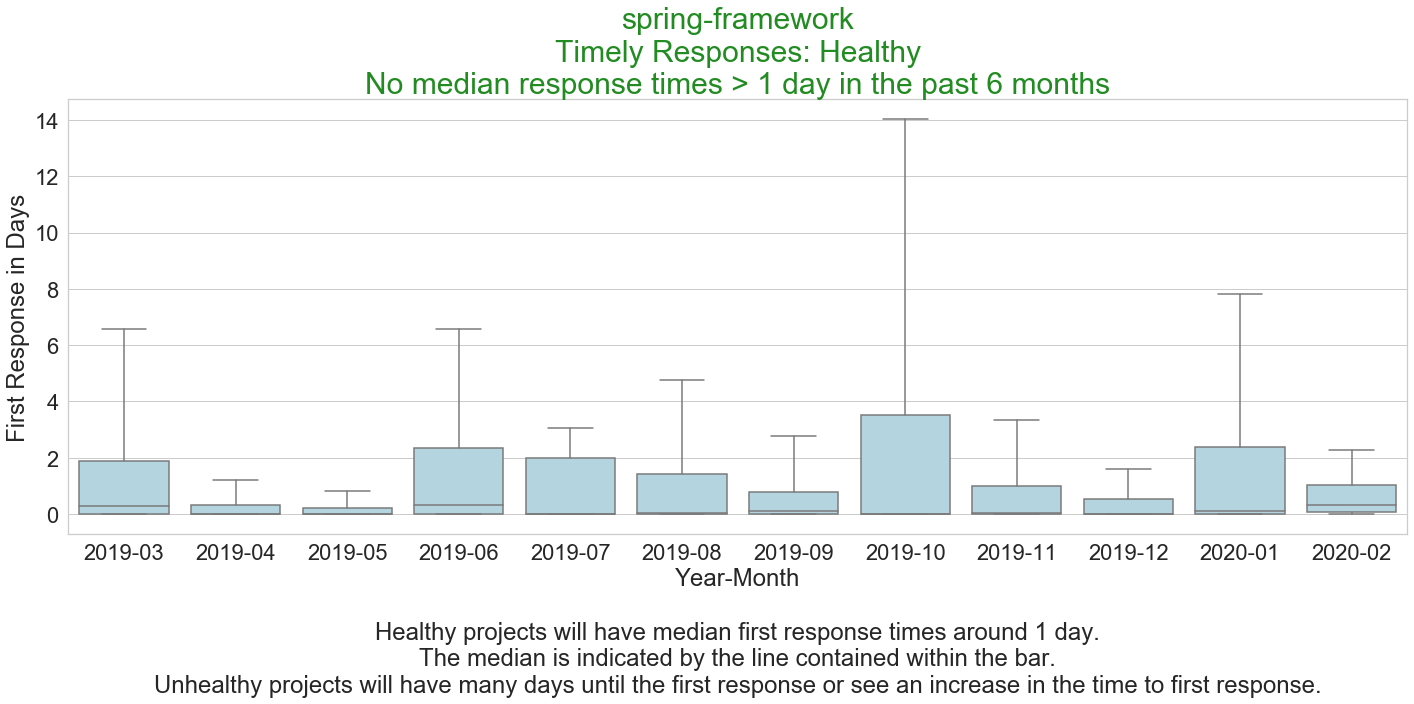

In [13]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()
fig.set_size_inches(24, 8)

title = repo_name + "\nTimely Responses:"

if risk_num >= 1:
    title += " AT RISK\n" + str(risk_num) + " month(s) with median response times > 1 day in the past 6 months"
    title_color = 'firebrick'
else:
    title += " Healthy\nNo median response times > 1 day in the past 6 months"
    title_color = 'forestgreen'

my_plot = sns.boxplot(x='yearmonth', y='diff_days', palette=bar_colors, data=pr_all, ax=ax, order=year_month_list, showfliers = False, whis=3).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_ylabel('First Response in Days')
risk_bar_labels = ax.set_xlabel('Year-Month\n\nHealthy projects will have median first response times around 1 day.\nThe median is indicated by the line contained within the bar.\nUnhealthy projects will have many days until the first response or see an increase in the time to first response.')

In [14]:
plt.close(fig)